In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load both datasets
fake_df = pd.read_csv('data/Fake.csv')
true_df = pd.read_csv('data/True.csv')

# Add labels
fake_df['label'] = 'FAKE'
true_df['label'] = 'REAL'

# Combine into one
df = pd.concat([fake_df, true_df], ignore_index=True)

# Save combined dataset
df.to_csv('data/fake_or_real_news.csv', index=False)

print(df['label'].value_counts())
print(df.head())
print(df.isnull().sum())

label
FAKE    23481
REAL    21417
Name: count, dtype: int64
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date label  
0  December 31, 2017  FAKE  
1  December 31, 2017  FAKE  
2  December 30, 2017  FAKE  
3  December 29, 2017  FAKE  
4  December 25, 2017  FAKE  
title      0
text       0
subject    0
date 

In [3]:
print("Shape:", df.shape)

Shape: (44898, 5)


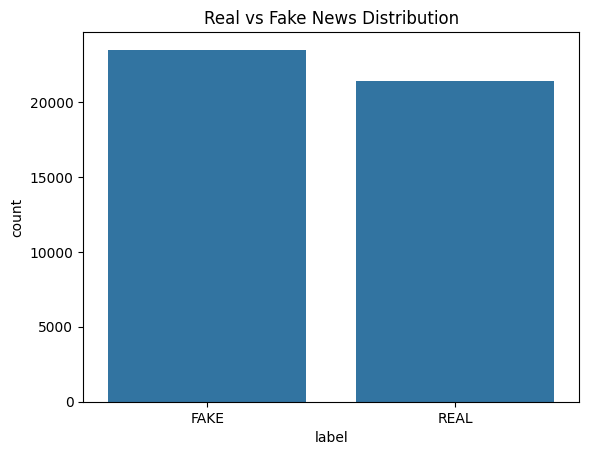

In [4]:
sns.countplot(data=df, x='label')
plt.title("Real vs Fake News Distribution")
plt.show()

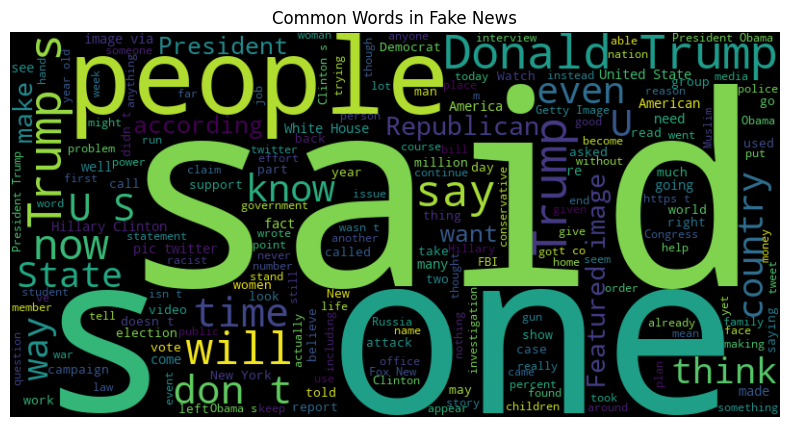

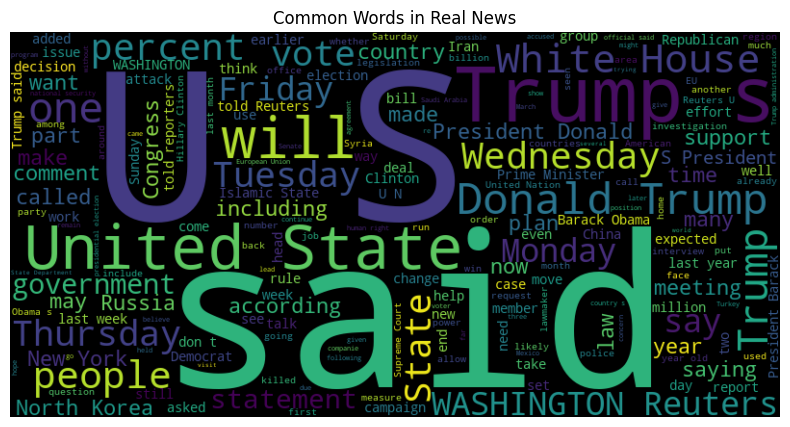

In [5]:
from wordcloud import WordCloud

# WordCloud for Fake
fake_text = " ".join(df[df['label']=='FAKE']['text'])
wordcloud_fake = WordCloud(width=800, height=400).generate(fake_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Fake News")
plt.show()

# WordCloud for Real
real_text = " ".join(df[df['label']=='REAL']['text'])
wordcloud_real = WordCloud(width=800, height=400).generate(real_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Real News")
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

predictions = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.9846325167037862
              precision    recall  f1-score   support

        FAKE       0.99      0.98      0.99      4733
        REAL       0.98      0.99      0.98      4247

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



In [8]:
y_pred = model.predict(X_test_tfidf)

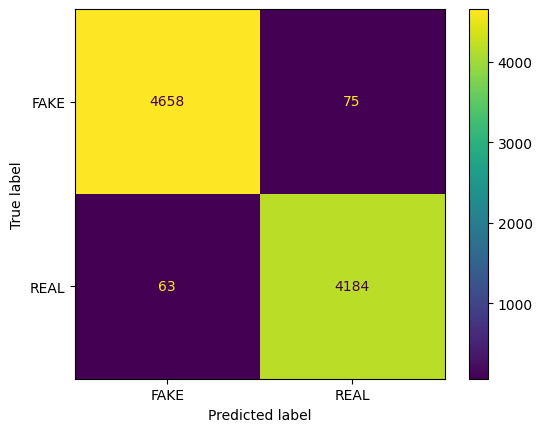

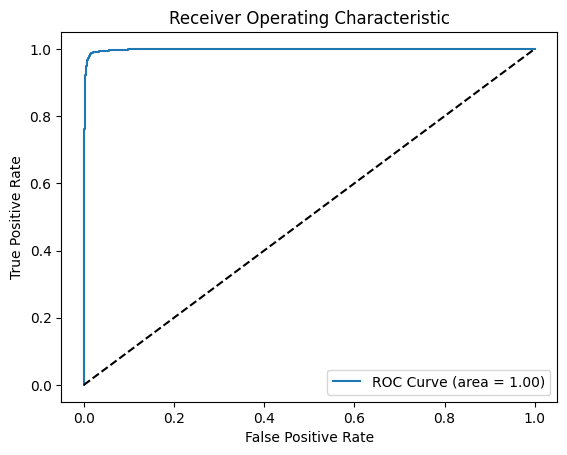

In [9]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

# ROC Curve
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test).ravel()

y_proba = model.predict_proba(X_test_tfidf)[:,1]
fpr, tpr, _ = roc_curve(y_test_binary, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [10]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.9327394209354121


In [11]:
from sklearn.model_selection import GridSearchCV

params = {
    'C': [0.1, 1, 10], 
    'max_iter': [100, 200]
}
grid = GridSearchCV(LogisticRegression(), param_grid=params, cv=3)
grid.fit(X_train_tfidf, y_train)
print("Best params:", grid.best_params_)

Best params: {'C': 10, 'max_iter': 100}


In [12]:
import pickle

# Save the trained model
with open('models/fake_news_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the TF-IDF vectorizer
with open('models/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [16]:
import feedparser
import pickle

# Load trained model and vectorizer
model = pickle.load(open('models/fake_news_model.pkl', 'rb'))
vectorizer = pickle.load(open('models/vectorizer.pkl', 'rb'))

# Example RSS Feed: BBC News
rss_url = 'http://feeds.bbci.co.uk/news/rss.xml'
feed = feedparser.parse(rss_url)

print("\n--- LIVE NEWS FEED PREDICTIONS ---\n")

for entry in feed.entries[:10]:  # Limit to 10 articles
    title = entry.title
    summary = entry.summary if 'summary' in entry else ''
    text = title + " " + summary

    # Vectorize and predict
    text_vector = vectorizer.transform([text])
    prediction = model.predict(text_vector)[0]

    print(f"🔹 {title}")
    print(f"🧠 Prediction: {prediction}\n")


--- LIVE NEWS FEED PREDICTIONS ---

🔹 Babies made using three people's DNA are born free of hereditary disease
🧠 Prediction: FAKE

🔹 Starmer stamps authority with MP suspensions, but risks appearing vindictive
🧠 Prediction: FAKE

🔹 US says 'specific steps' agreed to end Syria violence after Israeli strikes hit Damascus
🧠 Prediction: FAKE

🔹 UK jobs market cools as unemployment rate rises
🧠 Prediction: FAKE

🔹 Busiest UK airports raise kiss-and-fly fees, says RAC
🧠 Prediction: FAKE

🔹 New photo to mark Queen Camilla's 78th birthday
🧠 Prediction: FAKE

🔹 'It's just better!' Trump says Coca-Cola to change key US ingredient
🧠 Prediction: FAKE

🔹 MoD offered to speed up resettlement case of Afghan who posted data breach names on Facebook
🧠 Prediction: FAKE

🔹 Labour MP Diane Abbott stands by racism comments
🧠 Prediction: FAKE

🔹 Germany to tighten people-smuggling law as chancellor visits UK
🧠 Prediction: FAKE

